In [1]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp

import warnings

from tqdm import tqdm_notebook as tqdm

In [2]:
dt = 1 * u.Myr
t1 = 0.0 * u.Gyr
t2 = 5.0 * u.Gyr

In [32]:
mw = gp.MilkyWayPotential()

In [30]:
def euler_matrix(theta, inv=False) :
    theta = np.array(theta)
    if inv:
        theta = -theta
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         np.cos(theta[0]), -np.sin(theta[0]) ],
                    [0,         np.sin(theta[0]), np.cos(theta[0])  ]
                    ])
    R_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                    ])
    R_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                    [np.sin(theta[2]),    np.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
    if inv:
        R = np.dot(R_x, np.dot(R_y, R_z))
    else:
        R = np.dot(R_z, np.dot( R_y, R_x ))
    return R

def euler_rotate(theta, vec, inv=False):
    mat = euler_matrix(theta, inv)
    return np.transpose(np.tensordot(mat, np.transpose(vec), axes=1))

In [82]:
def compute_actions_wrong_ref_frame(init_pos, init_vel, offset, theta=None, cadence=25):
    if theta is None:
        theta = np.array([0.0, 0.0, 0.0])
    
    q = gd.PhaseSpacePosition(pos=init_pos, vel=init_vel)
    with warnings.catch_warnings(record=True):
        warnings.simplefilter("ignore")
        orbit = mw.integrate_orbit(q, dt=dt, t1=t1, t2=t2)
        res = gd.find_actions(orbit, N_max=8)
        ans = res['actions'].to(u.kpc * u.km / u.s).value
        print(ans)
    
    pos = np.transpose(orbit.pos.xyz.to_value(u.kpc))
    offset = offset.to_value(u.kpc)
    pos = np.add(pos, offset)
    vel = np.transpose(orbit.vel.d_xyz.to_value(u.km/u.s))
    rot_pos = np.transpose(euler_rotate(theta, pos))
    rot_vel = np.transpose(euler_rotate(theta, vel))
    rot_q = gd.PhaseSpacePosition(pos=rot_pos * u.kpc, vel=rot_vel * u.km/u.s)
    
    out_action = []
    time = orbit.t[::cadence]
    with warnings.catch_warnings(record=True):
        warnings.simplefilter("ignore")
        for this_q in tqdm(rot_q[::cadence]):
            this_orbit = mw.integrate_orbit(this_q, dt=dt, t1=t1, t2=t2, Integrator=gi.DOPRI853Integrator)
            res = gd.actionangle.find_actions(this_orbit, N_max=8)
            ans = res['actions'].to(u.kpc * u.km / u.s).value
            out_action.append(ans)
    return time, np.array(out_action)

In [96]:
def plot_wrong_act(t, act):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].plot(t, act[:,0])
    ax[1].plot(t, act[:,1])
    ax[2].plot(t, act[:,2])

    ax[0].set_xlim(0, 1500)
    ax[1].set_xlim(0, 1500)
    ax[2].set_xlim(0, 1500)

    for x in ax:
        x.set_xlabel('time [Myr]')
    ax[0].set_ylabel('J_r [kpc km/s]')
    ax[1].set_ylabel('L_z [kpc km/s]')
    ax[2].set_ylabel('J_z [kpc km/s]')

    fig.tight_layout()

In [88]:
def rad_to_deg(deg):
    return deg * (np.pi/180)

[   32.54989686 -1519.99999516    22.96531708]


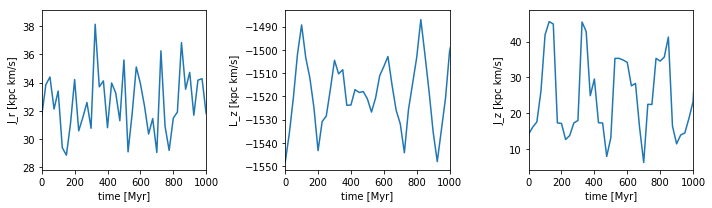

In [90]:
init_pos = [8, 0, 0] * u.kpc
init_vel = [0, -190, 50] * u.km/u.s

offset = [50, 0, 100] * u.pc
theta = [rad_to_deg(3), 0.0, 0.0]

t, act = compute_actions_wrong_ref_frame(init_pos, init_vel, offset, theta)
plot_wrong_act(t, act)

[   32.54989686 -1519.99999516    22.96531708]


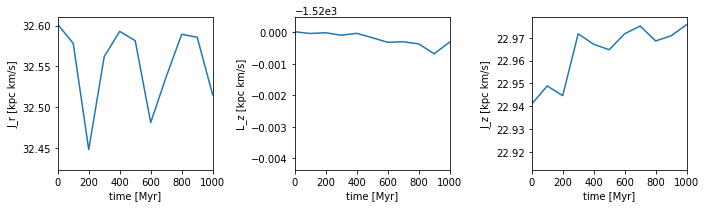

In [93]:
init_pos = [8, 0, 0] * u.kpc
init_vel = [0, -190, 50] * u.km/u.s

offset = [0, 0, 0] * u.pc
theta = [0, 0.0, 0.0]

t, act = compute_actions_wrong_ref_frame(init_pos, init_vel, offset, theta, cadence=100)
plot_wrong_act(t, act)

[   32.54989686 -1519.99999516    22.96531708]


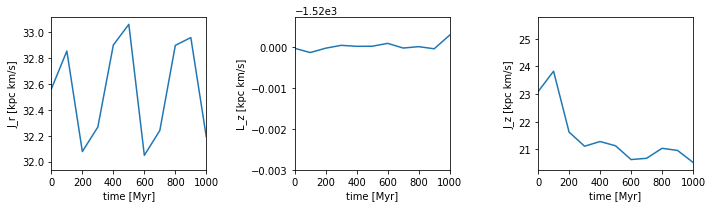

In [95]:
init_pos = [8, 0, 0] * u.kpc
init_vel = [0, -190, 50] * u.km/u.s

offset = [0, 0, 50] * u.pc
theta = [0, 0.0, 0.0]

t, act = compute_actions_wrong_ref_frame(init_pos, init_vel, offset, theta, cadence=100)
plot_wrong_act(t, act)